Precificação da opção de compra de R$1000.00 do ativo para o tempo presente, considerando que o ativo tem preço de R$1.00 hoje: R$11.16


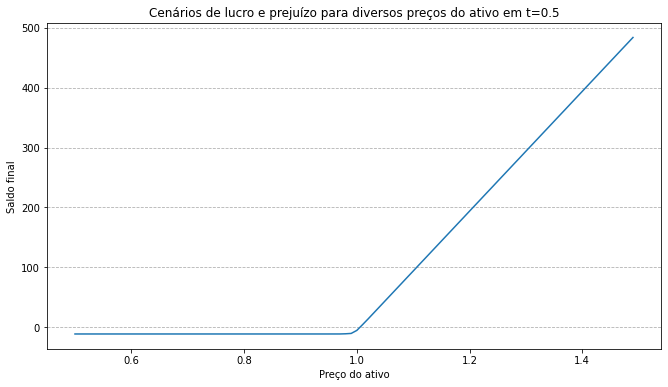

Precificação da opção de compra de R$1000.00 do ativo mudando apenas a volatilidade para 0.02: R$14.07


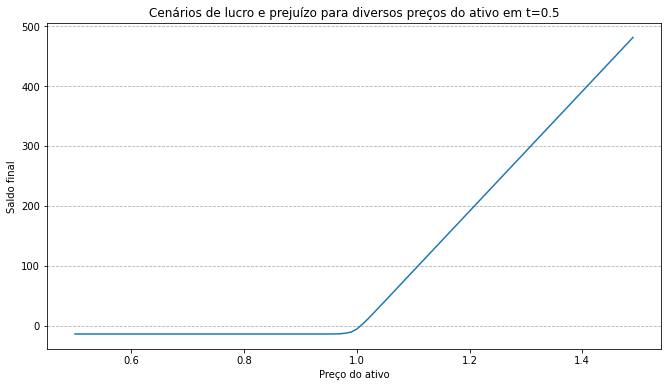

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import time
#import seaborn as sns

#biblioteca para obter a distribuicao normal acumulada
from scipy.stats import norm 

def calcula_u(N, M, L, sigma, K, T, vetoriza = True):
    delta_x     = 2*L/N
    delta_tal   = T/M 

    u = np.zeros((N+1, M+1))
    
    if vetoriza:
        #Calculando a base
        
        for i in range(N+1):
            x_i = i*delta_x-L

            u[i][0] = K*max(np.e**x_i - 1, 0)

        for j in range(M+1):
            tal_j = j * delta_tal

            u[N][j] = K * np.e**(L+sigma**2*tal_j/2)
            u[0][j] = 0
    

        # Calculando as demais posicoes
        for j in range(M):
            tal_j = j * delta_tal
        
            u_i_menos_um    = u[0:-2, j]
            u_i             = u[1:-1, j]
            u_i_mais_um     = u[2:  , j]

            u[1:-1, j+1]    = u_i + (delta_tal/delta_x**2)*(sigma**2/2)*(u_i_menos_um-2*u_i+u_i_mais_um)
    
    else:
        for j in range(M+1):
            tal_j = j * delta_tal
            for i in range(N+1):
                x_i = i*delta_x-L
                
                if i == 0:
                    u[i][j] = 0

                elif i == N:
                    u[i][j] = K * np.e**(L+sigma**2*tal_j/2)

                elif j==0:
                    u[i][j] = K*max(np.e**x_i - 1, 0)

                else:
                    u[i][j] = u[i][j-1] + (delta_tal/delta_x**2)*(sigma**2/2)*(u[i-1][j-1]-2*u[i][j-1]+u[i+1][j-1])


    return u         


def calcula_V(u, N, M, r, T):
    delta_tal   = T/M 
    V = np.zeros((N+1, M+1)) 
    for j in range(M+1):
        tal_j = j * delta_tal
        V[:, j] = u[:, j] * np.e**(-r*tal_j)

    return V


def calcula_S(N, M, L, sigma, K, T, r):
    delta_x     = 2*L/N
    delta_tal   = T/M 

    S1 = np.zeros((N+1, M+1)) # e^x_i
    S2 = np.zeros((N+1, M+1)) # e^((r-sigma^2/2)*tal_j)
    S  = np.zeros((N+1, M+1)) # K * (S1/S2)

    for j in range(M+1):
        tal_j = j * delta_tal
        S2[:, j] =  np.e**((r-sigma**2/2)*tal_j)

    for i in range(N+1):
        x_i = i*delta_x-L
        S1[i, :] = np.e**(x_i)

    S = K * (S1/S2)
    return S

def calcula_u_analitico(N, M, L, sigma, K, T):
    delta_x     = 2*L/N
    delta_tal   = T/M 

    u = np.zeros((N+1, M+1))
    for j in range(M+1):
        tal_j = j * delta_tal
        for i in range(N+1):
            x_i = i*delta_x-L
            if j==0:
                u[i][j] = K*max(np.e**x_i-1, 0)
            else:    
                d1 = (x_i + sigma**2*tal_j)/(sigma*np.sqrt(tal_j))
                d2 = x_i/(sigma*np.sqrt(tal_j))
                N1 = norm.cdf(d1)
                N2 = norm.cdf(d2)

                u[i][j] = K*np.e**(x_i + sigma**2*tal_j/2)*N1-K*N2
    return u

def calcula_aproximacao_V(V, S, t, N, M, L, sigma, K, T, r, interpola = True):
    delta_x     = 2*L/N
    delta_tal   = T/M 
    
    tal = T-t
    x = np.log(S/K) + (r-sigma**2/2)*tal

    i_p = int((x+L)/delta_x)
    j_p = round(tal/delta_tal)

    if interpola:
        x_i         = i_p*delta_x-L
        x_i_mais_um = (i_p+1)*delta_x-L
        opcao =  ((x_i_mais_um-x)*V[i_p][j_p]-(x_i-x)*V[i_p+1][j_p])/(x_i_mais_um-x_i)
        return opcao
    else:
        return V[i_p][j_p]


def cenario_1(show_graph=True):
    arquivo = open("report_cenario_1.txt", "w") 
    N       = 1000
    L       = 10
    M       = 10
    K       = 1
    sigma   = 0.01
    T       = 1
    r       = 0.01
    u = calcula_u(N, M, L, sigma, K, T)
    V = calcula_V(u, N, M, r, T)

    S = 1
    t = 0

    preco_opcao_agora = calcula_aproximacao_V(V, S, t, N, M, L, sigma, K, T, r)
    imprime_report(arquivo, N, L, M, K, sigma, T, r, S, t, preco_opcao_agora)

    opcao_compra_1000 = preco_opcao_agora*1000
    
    print("Precificação da opção de compra de R$1000.00 do ativo para o tempo presente, considerando que o ativo tem preço de R$1.00 hoje: R${:.2f}".format(opcao_compra_1000))
    
    gera_cenarios_lucro(V, 0.5, N, M, L, sigma, K, T, r, opcao_compra_1000, show_graph, "Cenários de lucro e prejuízo para diversos preços do ativo em t=0.5", "grafico_1_cenario_1.png")

    sigma = 0.02
    u = calcula_u(N, M, L, sigma, K, T)
    V = calcula_V(u, N, M, r, T)

    preco_opcao_agora = calcula_aproximacao_V(V, S, t, N, M, L, sigma, K, T, r)
    imprime_report(arquivo, N, L, M, K, sigma, T, r, S, t, preco_opcao_agora)

    opcao_compra_1000 = preco_opcao_agora*1000
    
    print("Precificação da opção de compra de R$1000.00 do ativo mudando apenas a volatilidade para 0.02: R${:.2f}".format(opcao_compra_1000))
    
    gera_cenarios_lucro(V, 0.5, N, M, L, sigma, K, T, r, opcao_compra_1000, show_graph, "Cenários de lucro e prejuízo para diversos preços do ativo em t=0.5", "grafico_2_cenario_1.png")
    
    arquivo.close()
    return 

def imprime_report(arquivo, N, L, M, K, sigma, T, r, S, t, V):
    arquivo.write("Parametros:\n")
    arquivo.write("N        = {}\n".format(N))
    arquivo.write("L        = {}\n".format(L))
    arquivo.write("M        = {}\n".format(M))
    arquivo.write("K        = {:.2f}\n".format(K))
    arquivo.write("sigma    = {:.2f}\n".format(sigma))
    arquivo.write("T        = {:.2f}\n".format(T))
    arquivo.write("r        = {:.2f}\n".format(r))
    arquivo.write("S0       = {:.2f}\n".format(S))
    arquivo.write("t        = {:.2f}\n".format(t))
    arquivo.write("Precificacao opcao:\n")
    arquivo.write("V        = {:.2f}\n".format(V))
    arquivo.write("\n\n")
    return 

def gera_cenarios_lucro(V, t, N, M, L, sigma, K, T, r, gasto_inicial, show_graph, titulo = "", nome_imagem = ""):
    k       = 100
    S_min   = K/2
    S_max   = 3*K/2   
    delta_S = (S_max-S_min)/k
    k_i     = np.arange(k)
    S_list  = k_i*delta_S+S_min 
    cenarios = []
    for S_i in S_list:
        resultado_i = calcula_aproximacao_V(V, S_i, t, N, M, L, sigma, K, T, r)*1000-gasto_inicial
        cenarios.append(resultado_i)

    if show_graph:
        fig, ax = plt.subplots(figsize = (11, 6))
        ax.plot(S_list, cenarios)
        ax.grid(visible = True, axis = "y", linestyle = "--")
        ax.set_title(titulo)
        ax.set_xlabel("Preço do ativo")
        ax.set_ylabel("Saldo final")
        plt.savefig(nome_imagem)
        plt.show()
    return cenarios

cenario_1()

In [90]:
def compara_tempo_execucao():
    tic = time.process_time()
    u   = calcula_u(1000,500, 10, 0.2, 1, 1, vetoriza=False) 
    toc = time.process_time()
    no_vectorization = (toc-tic)*1000
    tic = time.process_time()
    u   = calcula_u(1000,500, 10, 0.2, 1, 1) 
    toc = time.process_time()
    vectorization = (toc-tic)*1000
    print("Tempo de execução do método sem vetorização {:.2f} ms".format(no_vectorization))
    print("Tempo de execução do método com vetorização {:.2f} ms".format(vectorization))
    return